In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [34]:
plt.style.use('ggplot')
plt.style.use('seaborn-bright')

In [2]:
voice_usage_info = pd.read_csv("data/VOICE_INCOMING_CALL_USAGE_IDD.csv")

voice_usage_info

,event_source,event_source.hash,call_count,duration (seconds),ym,rtom_code,location_code,msan,equp_id,equp_index
0,672221677,b99957e9215d70ac90b5819e405827f7,2,458,202002,R-KL,KL-PRC-NODE,ZXDSL9806H-ISL,48236,1
1,242228729,61242a1f704099c655f84ef4fc0af8fd,9,4440,201912,R-VA,VA-NKM-NODE,MSAG5200-ISL,48196,1
2,672221677,b99957e9215d70ac90b5819e405827f7,2,56,202005,R-KL,KL-PRC-NODE,ZXDSL9806H-ISL,48236,1
3,242228729,61242a1f704099c655f84ef4fc0af8fd,2,736,201911,R-VA,VA-NKM-NODE,MSAG5200-ISL,48196,1
4,672221677,b99957e9215d70ac90b5819e405827f7,6,1001,201912,R-KL,KL-PRC-NODE,ZXDSL9806H-ISL,48236,1
...,...,...,...,...,...,...,...,...,...,...
5126,112727670,a0723957ebd80e956172f8424d6d530f,5,11352,202001,R-RM,MV-GDM-NODE,MSAG5200-ISL,48249,1
5127,112727670,a0723957ebd80e956172f8424d6d530f,3,7142,202008,R-RM,MV-GDM-NODE,MSAG5200-ISL,48249,1
5128,112727670,a0723957ebd80e956172f8424d6d530f,6,7328,202002,R-RM,MV-GDM-NODE,MSAG5200-ISL,48249,1
5129,112727670,a0723957ebd80e956172f8424d6d530f,4,11493,202004,R-RM,MV-GDM-NODE,MSAG5200-ISL,48249,1


In [3]:
# Handle null values
# Drop unnecessary cols
# Pivot by monthYear
# Usage rating Call Count/Duration - bucketizing/ add rating cols
# location grouping/bucketizing (consider 4 location cols)
# User profile dim table
# visualize and analyze data

In [4]:
voice_usage_info = voice_usage_info.drop_duplicates(["event_source.hash","ym"], keep="last")

voice_usage_info.shape

(5131, 10)

In [5]:
voice_usage_info = voice_usage_info.drop(['event_source'], axis=1)
voice_usage_info.rename(columns={'duration (seconds)': 'duration','ym':'year-month'}, inplace=True)
voice_usage_info

,event_source.hash,call_count,duration,year-month,rtom_code,location_code,msan,equp_id,equp_index
0,b99957e9215d70ac90b5819e405827f7,2,458,202002,R-KL,KL-PRC-NODE,ZXDSL9806H-ISL,48236,1
1,61242a1f704099c655f84ef4fc0af8fd,9,4440,201912,R-VA,VA-NKM-NODE,MSAG5200-ISL,48196,1
2,b99957e9215d70ac90b5819e405827f7,2,56,202005,R-KL,KL-PRC-NODE,ZXDSL9806H-ISL,48236,1
3,61242a1f704099c655f84ef4fc0af8fd,2,736,201911,R-VA,VA-NKM-NODE,MSAG5200-ISL,48196,1
4,b99957e9215d70ac90b5819e405827f7,6,1001,201912,R-KL,KL-PRC-NODE,ZXDSL9806H-ISL,48236,1
...,...,...,...,...,...,...,...,...,...
5126,a0723957ebd80e956172f8424d6d530f,5,11352,202001,R-RM,MV-GDM-NODE,MSAG5200-ISL,48249,1
5127,a0723957ebd80e956172f8424d6d530f,3,7142,202008,R-RM,MV-GDM-NODE,MSAG5200-ISL,48249,1
5128,a0723957ebd80e956172f8424d6d530f,6,7328,202002,R-RM,MV-GDM-NODE,MSAG5200-ISL,48249,1
5129,a0723957ebd80e956172f8424d6d530f,4,11493,202004,R-RM,MV-GDM-NODE,MSAG5200-ISL,48249,1


In [6]:
voice_usage_info['duration'].fillna(0)
voice_usage_info['call_count'].fillna(0)

0       2
1       9
2       2
3       2
4       6
       ..
5126    5
5127    3
5128    6
5129    4
5130    2
Name: call_count, Length: 5131, dtype: int64

In [7]:
voice_usage_info.isnull().sum(axis=0)

event_source.hash    0
call_count           0
duration             0
year-month           0
rtom_code            0
location_code        0
msan                 0
equp_id              0
equp_index           0
dtype: int64

# Phase 1

## Usage Ranking

- 1. Pivot by year-month
- 2. Bin by Call Counts/Duration
- 3. Usage Rank
- 4. Labling usage

In [19]:
voice_usage = voice_usage_info[['event_source.hash','call_count','duration','year-month']]
voice_usage


,event_source.hash,call_count,duration,year-month
0,b99957e9215d70ac90b5819e405827f7,2,458,202002
1,61242a1f704099c655f84ef4fc0af8fd,9,4440,201912
2,b99957e9215d70ac90b5819e405827f7,2,56,202005
3,61242a1f704099c655f84ef4fc0af8fd,2,736,201911
4,b99957e9215d70ac90b5819e405827f7,6,1001,201912
...,...,...,...,...
5126,a0723957ebd80e956172f8424d6d530f,5,11352,202001
5127,a0723957ebd80e956172f8424d6d530f,3,7142,202008
5128,a0723957ebd80e956172f8424d6d530f,6,7328,202002
5129,a0723957ebd80e956172f8424d6d530f,4,11493,202004


### IDD Usage Trend Analysis

In [20]:
voice_usage_for_plot = voice_usage
voice_usage_for_plot["year-month"] = voice_usage_for_plot["year-month"].astype("category")

<ipython-input-20-6904f4f60890>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voice_usage_for_plot["year-month"] = voice_usage_for_plot["year-month"].astype("category")


Text(0.5, 0.98, 'Call Duration trend')

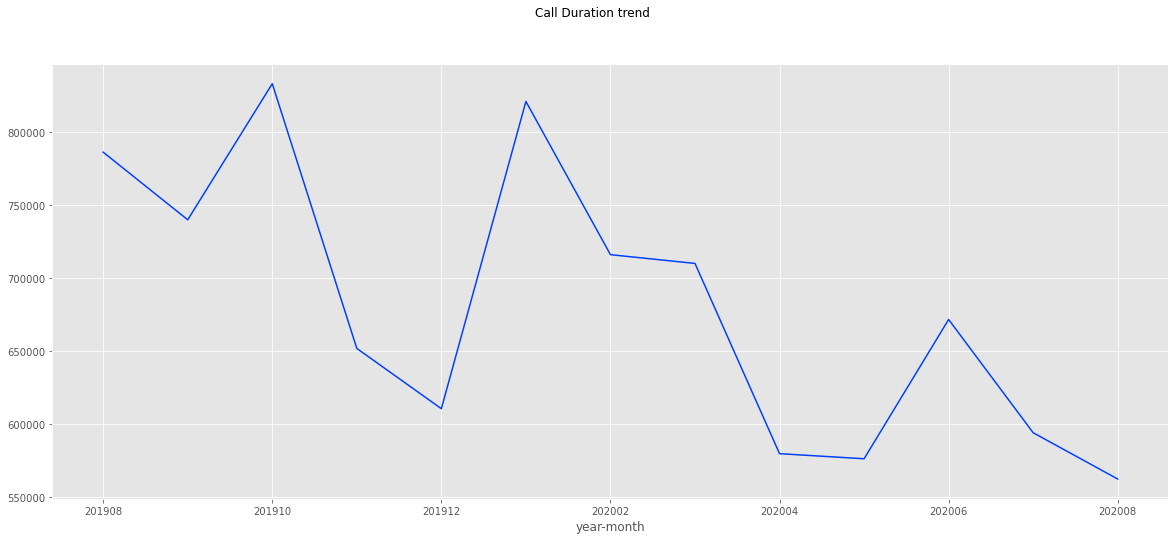

In [44]:
plt.figure(figsize=(20,8))
voice_usage_for_plot.groupby("year-month").sum()["duration"].plot()
plt.suptitle("Call Duration trend")

Text(0.5, 0.98, 'Call Counts trend')

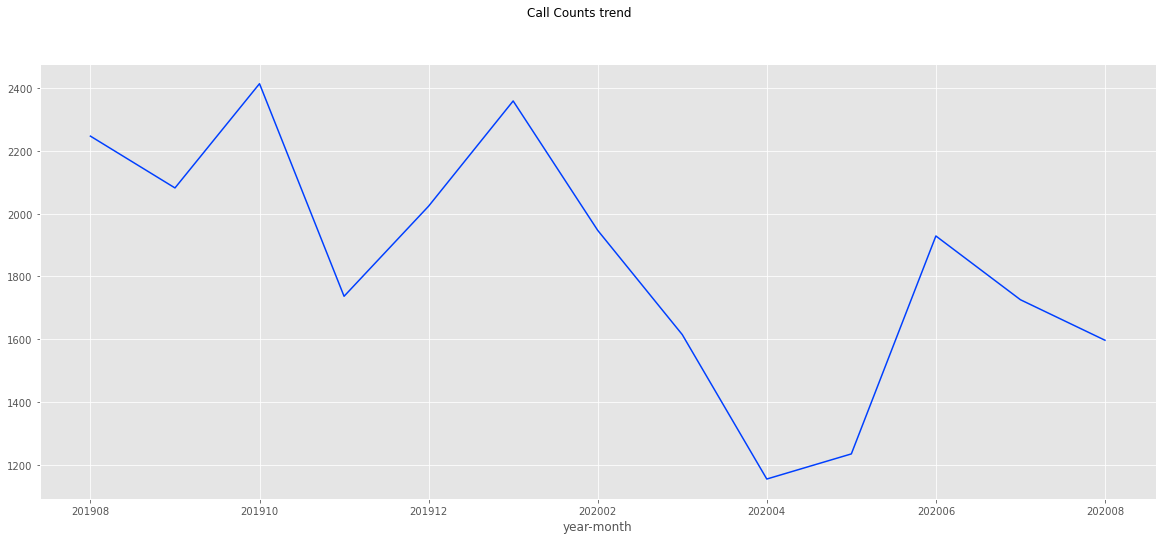

In [43]:
plt.figure(figsize=(20,8))
voice_usage_for_plot.groupby("year-month").sum()["call_count"].plot()
plt.suptitle("Call Counts trend")

In [16]:
pivot_voice_usage_info = pd.pivot_table(voice_usage,index=['event_source.hash'],columns=['year-month'], aggfunc=np.sum, fill_value=0)
pivot_voice_usage_info

call_count                              \
year-month                           201908 201909 201910 201911 201912   
event_source.hash                                                         
002fb47f60400713c854b0f69ff78c0a          0      0      1      0      0   
007400db8afa996e788d23986739f3db          5      0      0      0      1   
009f305bf85a71012c0e343233e611ba         16     19     19      7      8   
011adeeaef79aeac706a2e7fc225e8f8          0      1      0      0      0   
013736757d2ddad83cdfaa418921605c          0      1      0      0      0   
...                                     ...    ...    ...    ...    ...   
fefee9a8aed82517d62c14ea4793bf0a          1      0      4      0      0   
ff445f580f7525bd9f1455d6b09704cd          0      0      0      0      2   
ff7e0f4edb7b39b683b9134af37fc4d3          9      6      6      6      5   
ffb4fa6778bc5b3d9c858f5f4fa1e0c2          0      0      0      0      0   
ffd96f173d6cd683bf3384bdc2f99713          1      3      2      0      3   

                                                                     ...  \
year-month                       202001 202002 202003 202004 202005  ...   
event_source.hash                                                    ...   
002fb47f60400713c854b0f69ff78c0a      0      0      0      0      0  ...   
007400db8afa996e788d23986739f3db      0      1      0      0      0  ...   
009f305bf85a71012c0e343233e611ba     21     16      5      0      5  ...   
011adeeaef79aeac706a2e7fc225e8f8      0      0      0      2      0  ...   
013736757d2ddad83cdfaa418921605c      0      0      0      0      0  ...   
...                                 ...    ...    ...    ...    ...  ...   
fefee9a8aed82517d62c14ea4793bf0a      1      1      1      0      0  ...   
ff445f580f7525bd9f1455d6b09704cd      0      2      0      0      0  ...   
ff7e0f4edb7b39b683b9134af37fc4d3      2     14      5     11     26  ...   
ffb4fa6778bc5b3d9c858f5f4fa1e0c2      0      0      1      0      0  ...   
ffd96f173d6cd683bf3384bdc2f99713      1      2      0      2      3  ...   

                                 duration                                     \
year-month                         201911 201912 202001 202002 202003 202004   
event_source.hash                                                              
002fb47f60400713c854b0f69ff78c0a        0      0      0      0      0      0   
007400db8afa996e788d23986739f3db        0     10      0    124      0      0   
009f305bf85a71012c0e343233e611ba      549   2153   4492   3460   1417      0   
011adeeaef79aeac706a2e7fc225e8f8        0      0      0      0      0   1310   
013736757d2ddad83cdfaa418921605c        0      0      0      0      0      0   
...                                   ...    ...    ...    ...    ...    ...   
fefee9a8aed82517d62c14ea4793bf0a        0      0     17     26     19      0   
ff445f580f7525bd9f1455d6b09704cd        0    291      0    688      0      0   
ff7e0f4edb7b39b683b9134af37fc4d3     2263   2560   2345   7142   3802   7418   
ffb4fa6778bc5b3d9c858f5f4fa1e0c2        0      0      0      0     60      0   
ffd96f173d6cd683bf3384bdc2f99713        0     25    114     92      0    745   

                                                              
year-month                       202005 202006 202007 202008  
event_source.hash                                             
002fb47f60400713c854b0f69ff78c0a      0     11      0      0  
007400db8afa996e788d23986739f3db      0      0      0      0  
009f305bf85a71012c0e343233e611ba    319   1935   4046   3057  
011adeeaef79aeac706a2e7fc225e8f8      0      0      0      0  
013736757d2ddad83cdfaa418921605c      0      0      0      0  
...                                 ...    ...    ...    ...  
fefee9a8aed82517d62c14ea4793bf0a      0      0      0      0  
ff445f580f7525bd9f1455d6b09704cd      0      0      0      0  
ff7e0f4edb7b39b683b9134af37fc4d3  24773   5313   4466   8820  
ffb4fa6778bc5b3d9c858f5f4fa1e0c2      0 

In [12]:
voice_usage.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,call_count,duration,year-month
count,5131.00000,5131.00000,5131.00000
mean,4.69051,1725.30306,201963.81427
std,9.83080,3519.70864,46.75324
min,1.00000,1.00000,201908.00000
25%,1.00000,127.00000,201910.00000
50%,2.00000,525.00000,202001.00000
75%,5.00000,1742.00000,202005.00000
max,314.00000,62113.00000,202008.00000


In [18]:
# Freedman-Diaconis’s Rule for binnig
hist_values = np.histogram_bin_edges(voice_usage["call_count"].values,bins="fd")
hist_values

array([  1.        ,   1.4637037 ,   1.92740741,   2.39111111,
         2.85481481,   3.31851852,   3.78222222,   4.24592593,
         4.70962963,   5.17333333,   5.63703704,   6.10074074,
         6.56444444,   7.02814815,   7.49185185,   7.95555556,
         8.41925926,   8.88296296,   9.34666667,   9.81037037,
        10.27407407,  10.73777778,  11.20148148,  11.66518519,
        12.12888889,  12.59259259,  13.0562963 ,  13.52      ,
        13.9837037 ,  14.44740741,  14.91111111,  15.37481481,
        15.83851852,  16.30222222,  16.76592593,  17.22962963,
        17.69333333,  18.15703704,  18.62074074,  19.08444444,
        19.54814815,  20.01185185,  20.47555556,  20.93925926,
        21.40296296,  21.86666667,  22.33037037,  22.79407407,
        23.25777778,  23.72148148,  24.18518519,  24.64888889,
        25.11259259,  25.5762963 ,  26.04      ,  26.5037037 ,
        26.96740741,  27.43111111,  27.89481481,  28.35851852,
        28.82222222,  29.28592593,  29.74962963,  30.21

In [12]:
# binning call_count
count_bins = [0,3,6,100,314]
for col in pivot_voice_usage_info['call_count'].columns:
    pivot_voice_usage_info['call_count'][col] = np.searchsorted(count_bins, pivot_voice_usage_info['call_count'][col].values)
pivot_voice_usage_info['call_count']

<ipython-input-12-14283cecf24d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_voice_usage_info['call_count'][col] = np.searchsorted(count_bins, pivot_voice_usage_info['call_count'][col].values)


year-month,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008
event_source.hash,,,,,,,,,,,,,
002fb47f60400713c854b0f69ff78c0a,0,0,1,0,0,0,0,0,0,0,1,0,0
007400db8afa996e788d23986739f3db,2,0,0,0,1,0,1,0,0,0,0,0,0
009f305bf85a71012c0e343233e611ba,3,3,3,3,3,3,3,2,0,2,3,3,3
011adeeaef79aeac706a2e7fc225e8f8,0,1,0,0,0,0,0,0,1,0,0,0,0
013736757d2ddad83cdfaa418921605c,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
fefee9a8aed82517d62c14ea4793bf0a,1,0,2,0,0,1,1,1,0,0,0,0,0
ff445f580f7525bd9f1455d6b09704cd,0,0,0,0,1,0,1,0,0,0,0,0,0
ff7e0f4edb7b39b683b9134af37fc4d3,3,2,2,2,2,1,3,2,3,3,2,1,3


In [13]:
# binning duration
duration_bins = [0, 120, 600, 1800,62113]
for col in pivot_voice_usage_info['duration'].columns:
    pivot_voice_usage_info['duration'][col] = np.searchsorted(duration_bins, pivot_voice_usage_info['duration'][col].values)
pivot_voice_usage_info['duration']

<ipython-input-13-cb880e52479f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_voice_usage_info['duration'][col] = np.searchsorted(duration_bins, pivot_voice_usage_info['duration'][col].values)


year-month,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008
event_source.hash,,,,,,,,,,,,,
002fb47f60400713c854b0f69ff78c0a,0,0,2,0,0,0,0,0,0,0,1,0,0
007400db8afa996e788d23986739f3db,2,0,0,0,1,0,2,0,0,0,0,0,0
009f305bf85a71012c0e343233e611ba,4,4,4,2,4,4,4,3,0,2,4,4,4
011adeeaef79aeac706a2e7fc225e8f8,0,2,0,0,0,0,0,0,3,0,0,0,0
013736757d2ddad83cdfaa418921605c,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
fefee9a8aed82517d62c14ea4793bf0a,1,0,3,0,0,1,1,1,0,0,0,0,0
ff445f580f7525bd9f1455d6b09704cd,0,0,0,0,2,0,3,0,0,0,0,0,0
ff7e0f4edb7b39b683b9134af37fc4d3,4,4,4,4,4,4,4,4,4,4,4,4,4


In [14]:
year_month_list = pivot_voice_usage_info['call_count'].columns

In [15]:
# multplying bins to get usage rating
for col in year_month_list:
    pivot_voice_usage_info[col] = pivot_voice_usage_info['call_count'][col]  * pivot_voice_usage_info['duration'][col]

## ToDO
- find a different approach other than product

### Justification
- 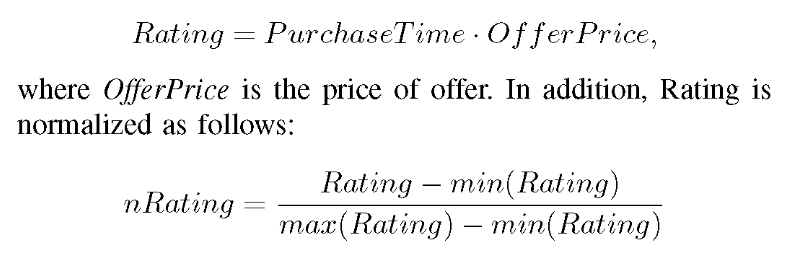
https://doi.org/10.1109/ICCE48956.2021.9352111, 2021  (Pham, C. D., Anh Chu, T., Pham, H. H., Linh Dao, M., Pham, T. S., Hung Trinh, V., & Nguyen, D. H. A recommendation system for offers in telecommunications)
- http://www.utstat.toronto.edu/~brunner/DataAnalysisText/Interactions.pdf

### More advanced methods
- Dimension reduction approaches?

### Usage ratings for year-month

In [16]:
pivot_voice_usage_info = pivot_voice_usage_info.drop(['call_count','duration'], axis=1)
pivot_voice_usage_info

,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008
year-month,,,,,,,,,,,,,
event_source.hash,,,,,,,,,,,,,
002fb47f60400713c854b0f69ff78c0a,0,0,2,0,0,0,0,0,0,0,1,0,0
007400db8afa996e788d23986739f3db,4,0,0,0,1,0,2,0,0,0,0,0,0
009f305bf85a71012c0e343233e611ba,12,12,12,6,12,12,12,6,0,4,12,12,12
011adeeaef79aeac706a2e7fc225e8f8,0,2,0,0,0,0,0,0,3,0,0,0,0
013736757d2ddad83cdfaa418921605c,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
fefee9a8aed82517d62c14ea4793bf0a,1,0,6,0,0,1,1,1,0,0,0,0,0
ff445f580f7525bd9f1455d6b09704cd,0,0,0,0,2,0,3,0,0,0,0,0,0


In [17]:
pivot_voice_usage_info.T.reset_index(drop=True).T
pivot_voice_usage_info.columns=year_month_list

In [18]:
# scaling usage rating
scaler = MinMaxScaler()
for col in year_month_list:
    pivot_voice_usage_info[col] = scaler.fit_transform(pivot_voice_usage_info[col].values.reshape(-1,1))

<AxesSubplot:xlabel='year-month', ylabel='event_source.hash'>

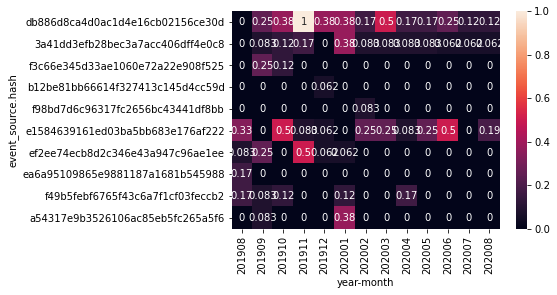

In [19]:
sns.heatmap(pivot_voice_usage_info[year_month_list].sample(n=10), annot=True)

In [20]:
pivot_voice_usage_info['Usage_Rating_Scaled'] = pivot_voice_usage_info[year_month_list].sum(axis=1)/len(year_month_list)
pivot_voice_usage_info

year-month,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008,Usage_Rating_Scaled
event_source.hash,,,,,,,,,,,,,,
002fb47f60400713c854b0f69ff78c0a,0.000000,0.000000,0.125,0.000000,0.0000,0.0000,0.000000,0.000000,0.00,0.000000,0.0625,0.0000,0.00,0.014423
007400db8afa996e788d23986739f3db,0.333333,0.000000,0.000,0.000000,0.0625,0.0000,0.166667,0.000000,0.00,0.000000,0.0000,0.0000,0.00,0.043269
009f305bf85a71012c0e343233e611ba,1.000000,1.000000,0.750,0.500000,0.7500,0.7500,1.000000,0.500000,0.00,0.333333,0.7500,0.7500,0.75,0.679487
011adeeaef79aeac706a2e7fc225e8f8,0.000000,0.166667,0.000,0.000000,0.0000,0.0000,0.000000,0.000000,0.25,0.000000,0.0000,0.0000,0.00,0.032051
013736757d2ddad83cdfaa418921605c,0.000000,0.083333,0.000,0.000000,0.0000,0.0000,0.000000,0.000000,0.00,0.000000,0.0000,0.0000,0.00,0.006410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fefee9a8aed82517d62c14ea4793bf0a,0.083333,0.000000,0.375,0.000000,0.0000,0.0625,0.083333,0.083333,0.00,0.000000,0.0000,0.0000,0.00,0.052885
ff445f580f7525bd9f1455d6b09704cd,0.000000,0.000000,0.000,0.000000,0.1250,0.0000,0.250000,0.000000,0.00,0.000000,0.0000,0.0000,0.00,0.028846
ff7e0f4edb7b39b683b9134af37fc4d3,1.000000,0.666667,0.500,0.666667,0.5000,0.2500,1.000000,0.666667,1.00,1.000000,0.5000,0.2500,0.75,0.673077


### Finding Outliers

<AxesSubplot:>

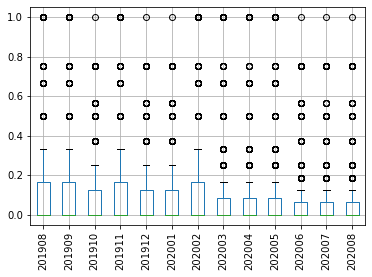

In [21]:
pivot_voice_usage_info.boxplot(column=[int(x) for x in year_month_list], rot=90)

<AxesSubplot:ylabel='year-month'>

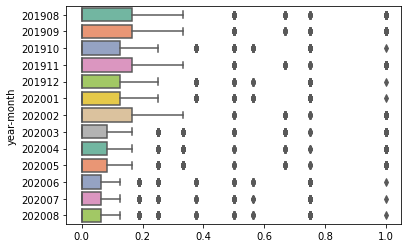

In [22]:
ax = sns.boxplot(data=pivot_voice_usage_info[[int(x) for x in year_month_list]], orient="h", palette="Set2")
ax

<AxesSubplot:ylabel='Density'>

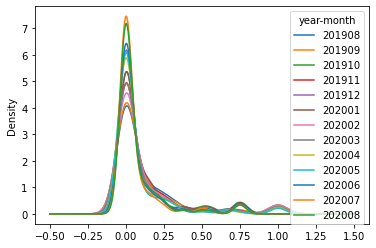

In [23]:
pivot_voice_usage_info[[int(x) for x in year_month_list]].plot(kind = 'density')

## Three quantitative methods commonly used in statistics for the detection of univariate outliers:
- Tukey’s box plot method
- Internally studentized residuals (AKA z-score method)
- Median Absolute Deviation method

### 1) Tukey’s box plot method
- Tukey distinguishes between possible and probable outliers. A possible outlier is located between the inner and the outer fence, whereas a probable outlier is located outside the outer fence.    
    
- IQR =Q3 - Q1, whereas q3 := 75th quartile and q1 := 25th quartile
- Inner fence = [Q1-1.5*IQR, Q3+1.5*IQR]
- Outer fence = [Q1–3*IQR, Q3+3*IQR]

In [24]:
#Tukey's method
def tukeys_method(df, variable):
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 3*iqr
    
    #inner fence lower and upper end
    inner_fence_le = q1-inner_fence
    inner_fence_ue = q3+inner_fence
    
    #outer fence lower and upper end
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    
    outliers_prob = []
    outliers_poss = []
    outliers_prob_indexes = []
    outliers_poss_indexes = []
    for index, x in enumerate(df[variable]):
        if x <= outer_fence_le or x >= outer_fence_ue:
            outliers_prob_indexes.append(index)
            outliers_prob.append(x)
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_poss_indexes.append(index)
            outliers_poss.append(x)
    # returns indexes of the rows with outliers
    return outliers_prob, outliers_prob_indexes, outliers_poss, outliers_poss_indexes

In [25]:
pr_col_threshold = []
po_col_threshold = []
for col in year_month_list:
    pr_col, pr_col_indexes, po_col, po_col_indexes = tukeys_method(pivot_voice_usage_info, int(col))
    pr_col_threshold.append({col: {"threshold": min(pr_col), "count": len(pr_col)}})
    po_col_threshold.append({col: {"threshold": min(po_col), "count": len(po_col)}})
    print()
    print(f"Probable Outliers for {col}---->\n", pr_col)
    print(len(pr_col))
    print()
    print(f"Possible Outliers for {col}----->\n", po_col)
    print(len(po_col))
    print()


Probable Outliers for 201908---->
 [1.0, 1.0, 1.0, 0.75, 0.6666666666666666, 0.75, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 0.75, 0.6666666666666666, 0.6666666666666666, 0.75, 1.0, 1.0, 0.75, 0.75, 1.0, 0.75, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 0.75, 0.75, 1.0, 1.0, 1.0, 0.75, 0.6666666666666666, 1.0, 0.75, 1.0, 0.6666666666666666, 0.75, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 0.75, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.75, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 0.6666666666666666, 0.6666666666666666, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
103

Possible Outliers for 201908----->
 [1.0, 1.0, 1.0, 0.5, 0.75, 0.5, 0.66666666666

In [26]:
pr_col_threshold

[{201908: {'threshold': 0.6666666666666666, 'count': 103}},
 {201909: {'threshold': 0.6666666666666666, 'count': 101}},
 {201910: {'threshold': 0.5, 'count': 120}},
 {201911: {'threshold': 0.6666666666666666, 'count': 78}},
 {201912: {'threshold': 0.5, 'count': 83}},
 {202001: {'threshold': 0.5, 'count': 109}},
 {202002: {'threshold': 0.6666666666666666, 'count': 97}},
 {202003: {'threshold': 0.3333333333333333, 'count': 148}},
 {202004: {'threshold': 0.3333333333333333, 'count': 108}},
 {202005: {'threshold': 0.3333333333333333, 'count': 106}},
 {202006: {'threshold': 0.25, 'count': 154}},
 {202007: {'threshold': 0.25, 'count': 116}},
 {202008: {'threshold': 0.25, 'count': 127}}]

In [27]:
po_col_threshold

[{201908: {'threshold': 0.5, 'count': 134}},
 {201909: {'threshold': 0.5, 'count': 130}},
 {201910: {'threshold': 0.375, 'count': 156}},
 {201911: {'threshold': 0.5, 'count': 105}},
 {201912: {'threshold': 0.375, 'count': 119}},
 {202001: {'threshold': 0.375, 'count': 148}},
 {202002: {'threshold': 0.5, 'count': 113}},
 {202003: {'threshold': 0.25, 'count': 203}},
 {202004: {'threshold': 0.25, 'count': 166}},
 {202005: {'threshold': 0.25, 'count': 167}},
 {202006: {'threshold': 0.1875, 'count': 203}},
 {202007: {'threshold': 0.1875, 'count': 162}},
 {202008: {'threshold': 0.1875, 'count': 184}}]

### 2) Median Absolute Deviation method
- this method is highly limited as the distributions mean and standard deviation are sensitive to outliers. This means that finding one outlier is dependent on other outliers as every observation directly affects the mean.    
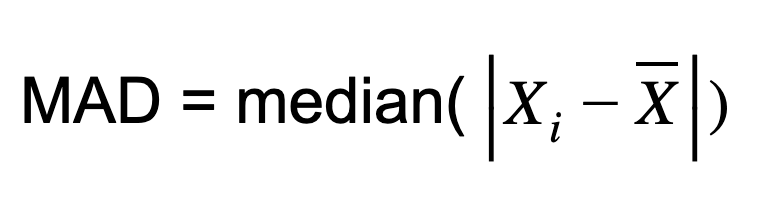

In [28]:
from scipy import stats

# MAD method
def mad_method(df, variable_name):
    #Takes two parameters: dataframe & variable of interest as string
    columns = df.columns
    med = np.median(df, axis = 0)
    mad = np.abs(stats.median_absolute_deviation(df))
    threshold = 3
    outlier = []
    index=0
    for item in range(len(columns)):
        if columns[item] == variable_name:
            index == item
    for i, v in enumerate(df.loc[:,variable_name]):
        t = (v-med[index])/mad[index]
        if t > threshold:
            outlier.append(i)
        else:
            continue
    return outlier

In [29]:
col_threshold = []
for col in year_month_list:
    outliers = mad_method(pivot_voice_usage_info, int(col))
    outlier_cols = pivot_voice_usage_info[int(col)].iloc[outliers]
    col_threshold.append({col: {"threshold" :min(outlier_cols), "count":len(outliers)}})
    print()
    print(f"Outliers for {col}---->\n", outlier_cols)
    print(len(outliers))


Outliers for 201908---->
 event_source.hash
007400db8afa996e788d23986739f3db    0.333333
009f305bf85a71012c0e343233e611ba    1.000000
0201ee9b60de662cdd16c885f178feea    0.250000
02567960cda70e799d691cf9e2ac479a    0.166667
029b57551e576f248ff07c849db52fd6    0.083333
                                      ...   
fdf1cca1f96ccf2fdf7426b6bd74309e    0.083333
fe20b17a9573e4b7e765cc3098728f3d    0.250000
fefee9a8aed82517d62c14ea4793bf0a    0.083333
ff7e0f4edb7b39b683b9134af37fc4d3    1.000000
ffd96f173d6cd683bf3384bdc2f99713    0.083333
Name: 201908, Length: 475, dtype: float64
475

Outliers for 201909---->
 event_source.hash
009f305bf85a71012c0e343233e611ba    1.000000
011adeeaef79aeac706a2e7fc225e8f8    0.166667
013736757d2ddad83cdfaa418921605c    0.083333
0152d7723febc8f6913e91db4887a75e    0.666667
0201ee9b60de662cdd16c885f178feea    0.166667
                                      ...   
fb74ed10935082136fe673b4609888af    0.083333
fd66267fedae84830de108c7d6bba3fe    0.083333
fe20b17a9

<ipython-input-28-ab658f4f8d27>:8: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  mad = np.abs(stats.median_absolute_deviation(df))
<ipython-input-28-ab658f4f8d27>:16: RuntimeWarning: invalid value encountered in double_scalars
  t = (v-med[index])/mad[index]
<ipython-input-28-ab658f4f8d27>:16: RuntimeWarning: divide by zero encountered in double_scalars
  t = (v-med[index])/mad[index]


In [30]:
col_threshold

[{201908: {'threshold': 0.08333333333333333, 'count': 475}},
 {201909: {'threshold': 0.08333333333333333, 'count': 453}},
 {201910: {'threshold': 0.0625, 'count': 448}},
 {201911: {'threshold': 0.08333333333333333, 'count': 408}},
 {201912: {'threshold': 0.0625, 'count': 417}},
 {202001: {'threshold': 0.0625, 'count': 475}},
 {202002: {'threshold': 0.08333333333333333, 'count': 402}},
 {202003: {'threshold': 0.08333333333333333, 'count': 378}},
 {202004: {'threshold': 0.08333333333333333, 'count': 310}},
 {202005: {'threshold': 0.08333333333333333, 'count': 311}},
 {202006: {'threshold': 0.0625, 'count': 371}},
 {202007: {'threshold': 0.0625, 'count': 316}},
 {202008: {'threshold': 0.0625, 'count': 367}}]

In [31]:
sum_outlier = 0
for col in col_threshold:
    for key,val in col.items():
        sum_outlier += val["threshold"]
avg_outlier = sum_outlier / len(col_threshold)
pivot_voice_usage_info["Outlier"]=pivot_voice_usage_info.apply(lambda x : "YES" if x["Usage_Rating_Scaled"]> avg_outlier else "NO", axis=1)
print(avg_outlier)

0.07371794871794873


In [32]:
pivot_voice_usage_info

year-month,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008,Usage_Rating_Scaled,Outlier
event_source.hash,,,,,,,,,,,,,,,
002fb47f60400713c854b0f69ff78c0a,0.000000,0.000000,0.125,0.000000,0.0000,0.0000,0.000000,0.000000,0.00,0.000000,0.0625,0.0000,0.00,0.014423,NO
007400db8afa996e788d23986739f3db,0.333333,0.000000,0.000,0.000000,0.0625,0.0000,0.166667,0.000000,0.00,0.000000,0.0000,0.0000,0.00,0.043269,NO
009f305bf85a71012c0e343233e611ba,1.000000,1.000000,0.750,0.500000,0.7500,0.7500,1.000000,0.500000,0.00,0.333333,0.7500,0.7500,0.75,0.679487,YES
011adeeaef79aeac706a2e7fc225e8f8,0.000000,0.166667,0.000,0.000000,0.0000,0.0000,0.000000,0.000000,0.25,0.000000,0.0000,0.0000,0.00,0.032051,NO
013736757d2ddad83cdfaa418921605c,0.000000,0.083333,0.000,0.000000,0.0000,0.0000,0.000000,0.000000,0.00,0.000000,0.0000,0.0000,0.00,0.006410,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fefee9a8aed82517d62c14ea4793bf0a,0.083333,0.000000,0.375,0.000000,0.0000,0.0625,0.083333,0.083333,0.00,0.000000,0.0000,0.0000,0.00,0.052885,NO
ff445f580f7525bd9f1455d6b09704cd,0.000000,0.000000,0.000,0.000000,0.1250,0.0000,0.250000,0.000000,0.00,0.000000,0.0000,0.0000,0.00,0.028846,NO
ff7e0f4edb7b39b683b9134af37fc4d3,1.000000,0.666667,0.500,0.666667,0.5000,0.2500,1.000000,0.666667,1.00,1.000000,0.5000,0.2500,0.75,0.673077,YES


In [33]:
# labling usage bins
bins = [0, 0.08, 0.3,1]
labels = ['LOW','MEDIUM','HIGH']
pivot_voice_usage_info['Usage_Rating_Categorical'] = pd.cut(pivot_voice_usage_info['Usage_Rating_Scaled'], bins=bins, labels=labels)
pivot_voice_usage_info

year-month,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008,Usage_Rating_Scaled,Outlier,Usage_Rating_Categorical
event_source.hash,,,,,,,,,,,,,,,,
002fb47f60400713c854b0f69ff78c0a,0.000000,0.000000,0.125,0.000000,0.0000,0.0000,0.000000,0.000000,0.00,0.000000,0.0625,0.0000,0.00,0.014423,NO,LOW
007400db8afa996e788d23986739f3db,0.333333,0.000000,0.000,0.000000,0.0625,0.0000,0.166667,0.000000,0.00,0.000000,0.0000,0.0000,0.00,0.043269,NO,LOW
009f305bf85a71012c0e343233e611ba,1.000000,1.000000,0.750,0.500000,0.7500,0.7500,1.000000,0.500000,0.00,0.333333,0.7500,0.7500,0.75,0.679487,YES,HIGH
011adeeaef79aeac706a2e7fc225e8f8,0.000000,0.166667,0.000,0.000000,0.0000,0.0000,0.000000,0.000000,0.25,0.000000,0.0000,0.0000,0.00,0.032051,NO,LOW
013736757d2ddad83cdfaa418921605c,0.000000,0.083333,0.000,0.000000,0.0000,0.0000,0.000000,0.000000,0.00,0.000000,0.0000,0.0000,0.00,0.006410,NO,LOW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fefee9a8aed82517d62c14ea4793bf0a,0.083333,0.000000,0.375,0.000000,0.0000,0.0625,0.083333,0.083333,0.00,0.000000,0.0000,0.0000,0.00,0.052885,NO,LOW
ff445f580f7525bd9f1455d6b09704cd,0.000000,0.000000,0.000,0.000000,0.1250,0.0000,0.250000,0.000000,0.00,0.000000,0.0000,0.0000,0.00,0.028846,NO,LOW
ff7e0f4edb7b39b683b9134af37fc4d3,1.000000,0.666667,0.500,0.666667,0.5000,0.2500,1.000000,0.666667,1.00,1.000000,0.5000,0.2500,0.75,0.673077,YES,HIGH


In [34]:
# adding category "NO" 
pivot_voice_usage_info['Usage_Rating_Categorical'] = pivot_voice_usage_info['Usage_Rating_Categorical'].cat.add_categories("NO")
pivot_voice_usage_info.loc[pivot_voice_usage_info['Usage_Rating_Scaled'] == 0.0, 'Usage_Rating_Categorical'] = "NO"
pivot_voice_usage_info[(pivot_voice_usage_info['Usage_Rating_Scaled'] == 0.0)]

year-month,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008,Usage_Rating_Scaled,Outlier,Usage_Rating_Categorical
event_source.hash,,,,,,,,,,,,,,,,


### Fina Result: Usage Ratings

In [35]:
pivot_voice_usage_info

year-month,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008,Usage_Rating_Scaled,Outlier,Usage_Rating_Categorical
event_source.hash,,,,,,,,,,,,,,,,
002fb47f60400713c854b0f69ff78c0a,0.000000,0.000000,0.125,0.000000,0.0000,0.0000,0.000000,0.000000,0.00,0.000000,0.0625,0.0000,0.00,0.014423,NO,LOW
007400db8afa996e788d23986739f3db,0.333333,0.000000,0.000,0.000000,0.0625,0.0000,0.166667,0.000000,0.00,0.000000,0.0000,0.0000,0.00,0.043269,NO,LOW
009f305bf85a71012c0e343233e611ba,1.000000,1.000000,0.750,0.500000,0.7500,0.7500,1.000000,0.500000,0.00,0.333333,0.7500,0.7500,0.75,0.679487,YES,HIGH
011adeeaef79aeac706a2e7fc225e8f8,0.000000,0.166667,0.000,0.000000,0.0000,0.0000,0.000000,0.000000,0.25,0.000000,0.0000,0.0000,0.00,0.032051,NO,LOW
013736757d2ddad83cdfaa418921605c,0.000000,0.083333,0.000,0.000000,0.0000,0.0000,0.000000,0.000000,0.00,0.000000,0.0000,0.0000,0.00,0.006410,NO,LOW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fefee9a8aed82517d62c14ea4793bf0a,0.083333,0.000000,0.375,0.000000,0.0000,0.0625,0.083333,0.083333,0.00,0.000000,0.0000,0.0000,0.00,0.052885,NO,LOW
ff445f580f7525bd9f1455d6b09704cd,0.000000,0.000000,0.000,0.000000,0.1250,0.0000,0.250000,0.000000,0.00,0.000000,0.0000,0.0000,0.00,0.028846,NO,LOW
ff7e0f4edb7b39b683b9134af37fc4d3,1.000000,0.666667,0.500,0.666667,0.5000,0.2500,1.000000,0.666667,1.00,1.000000,0.5000,0.2500,0.75,0.673077,YES,HIGH


In [36]:
pivot_voice_usage_info.to_csv("data/user_profile/VOICE_IDD_Incoming_Usage_Categorical.csv")

# Phase 2

## Binnig by Location 

- 1. group by location columns
- 2. Bin by location and get counts

In [37]:
# bucketing by location
voice_location_info = voice_usage_info
voice_location_info['Location_Identifier'] = voice_location_info['msan'].astype(str)+ voice_location_info['location_code'].astype(str) +voice_location_info['equp_id'].astype(str) +voice_location_info['equp_index'].astype(str)
voice_location_info

,event_source.hash,call_count,duration,year-month,rtom_code,location_code,msan,equp_id,equp_index,Location_Identifier
0,b99957e9215d70ac90b5819e405827f7,2,458,202002,R-KL,KL-PRC-NODE,ZXDSL9806H-ISL,48236,1,ZXDSL9806H-ISLKL-PRC-NODE482361
1,61242a1f704099c655f84ef4fc0af8fd,9,4440,201912,R-VA,VA-NKM-NODE,MSAG5200-ISL,48196,1,MSAG5200-ISLVA-NKM-NODE481961
2,b99957e9215d70ac90b5819e405827f7,2,56,202005,R-KL,KL-PRC-NODE,ZXDSL9806H-ISL,48236,1,ZXDSL9806H-ISLKL-PRC-NODE482361
3,61242a1f704099c655f84ef4fc0af8fd,2,736,201911,R-VA,VA-NKM-NODE,MSAG5200-ISL,48196,1,MSAG5200-ISLVA-NKM-NODE481961
4,b99957e9215d70ac90b5819e405827f7,6,1001,201912,R-KL,KL-PRC-NODE,ZXDSL9806H-ISL,48236,1,ZXDSL9806H-ISLKL-PRC-NODE482361
...,...,...,...,...,...,...,...,...,...,...
5126,a0723957ebd80e956172f8424d6d530f,5,11352,202001,R-RM,MV-GDM-NODE,MSAG5200-ISL,48249,1,MSAG5200-ISLMV-GDM-NODE482491
5127,a0723957ebd80e956172f8424d6d530f,3,7142,202008,R-RM,MV-GDM-NODE,MSAG5200-ISL,48249,1,MSAG5200-ISLMV-GDM-NODE482491
5128,a0723957ebd80e956172f8424d6d530f,6,7328,202002,R-RM,MV-GDM-NODE,MSAG5200-ISL,48249,1,MSAG5200-ISLMV-GDM-NODE482491
5129,a0723957ebd80e956172f8424d6d530f,4,11493,202004,R-RM,MV-GDM-NODE,MSAG5200-ISL,48249,1,MSAG5200-ISLMV-GDM-NODE482491


In [38]:
voice_location_info = voice_location_info.drop_duplicates("event_source.hash", keep="last")
voice_location_info.shape

(1197, 10)

In [39]:
user_location = voice_location_info[['event_source.hash','Location_Identifier']]
user_location

,event_source.hash,Location_Identifier
34,947309b9478fd3993b58804c268fe179,MSAG5200-ISLND-PHG-NODE500241
40,dce9f0e3ba96f0ea67e9681877b51006,MSAG5200PH-AKG-NODE431631
42,8d83cf8c3756b71d3977672bfdc0eca4,MSAG5200-ISLND-PHG-NODE500241
58,cc51c48ded68010b7ad9a97aa3d6e29e,C300MKI-NODE10668164
63,a4a7a596cbaf8cd93802488c61ae3b93,MSAG5200-ISLND-PHG-NODE500241
...,...,...
5112,3d08552dea86e84bb28ebe73413d850b,MSAG5200-ISLMV-GDM-NODE482491
5119,a9c275b5f18b1ade48fe5187e2d92308,MSAG5200-ISLMV-GDM-NODE482491
5124,bce831090f88a956c436f9467d8bfbe1,MSAG5200-ISLMV-GDM-NODE482491
5125,2d5aecc7b729e0a06fe42fc60364a02f,MSAG5200-ISLMV-GDM-NODE482491


In [40]:
user_location.to_csv("data/user_profile/VOICE_IDD_INCOMING_Locations_of_Users.csv")

In [41]:
voice_location_info["User_Count"] = 1
voice_gropued_by_locations = voice_location_info.groupby(['Location_Identifier'], axis=0,as_index=False).sum()
voice_gropued_by_locations = voice_gropued_by_locations[['Location_Identifier','User_Count']]

<ipython-input-41-46e54884d952>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voice_location_info["User_Count"] = 1


In [42]:
voice_gropued_by_locations

,Location_Identifier,User_Count
0,C300MHE-DMD-NODE15221561,3
1,C300MHT-NE-NODE8152461,5
2,C300MIDH-IDJ-NODE11065541,32
3,C300MKI-NODE10668164,39
4,C300MNW-MEE-NODE18887751,34
5,C300MPDT-NODE13379431,1
6,C300MTP-NODE8700911,6
7,C300MVH-NODE9874041,2
8,MA5603TAD-SRV-NODE10224991,3
9,MSAG5200-ISLBZ-NODE435881,32


In [43]:
voice_gropued_by_locations.to_csv("data/user_profile/VOICE_IDD_Users_Count_by_Location.csv")

<AxesSubplot:>

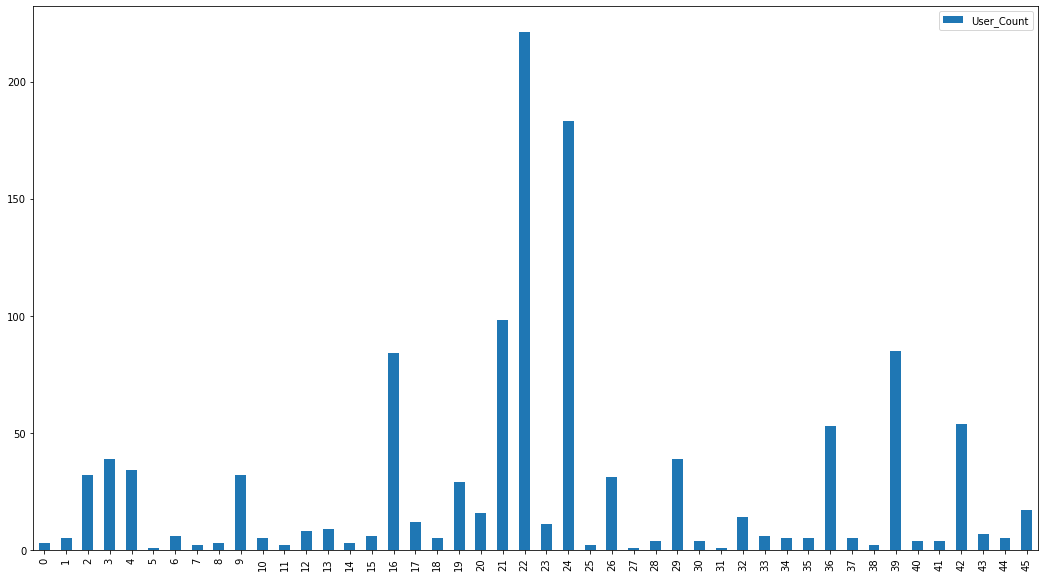

In [44]:
voice_gropued_by_locations.plot(kind="bar", figsize=(18,10),xticks=voice_gropued_by_locations.index)